# Predictive Survival Analysis

Whenever we have additional variables next to duration and event, we can use survival regression. 

# Survival Regression with Cox Proportional Hazard (CPH) Model

CT

## Fitting CPH Model

In [2]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

df = load_rossi()

cph = CoxPHFitter()
cph.fit(df, duration_col='week', event_col='arrest')

cph.print_summary()  

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-03-17 20:32:23 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

In [15]:
ax.ravel() 

array([<Axes: xlabel='age', ylabel='Count'>, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

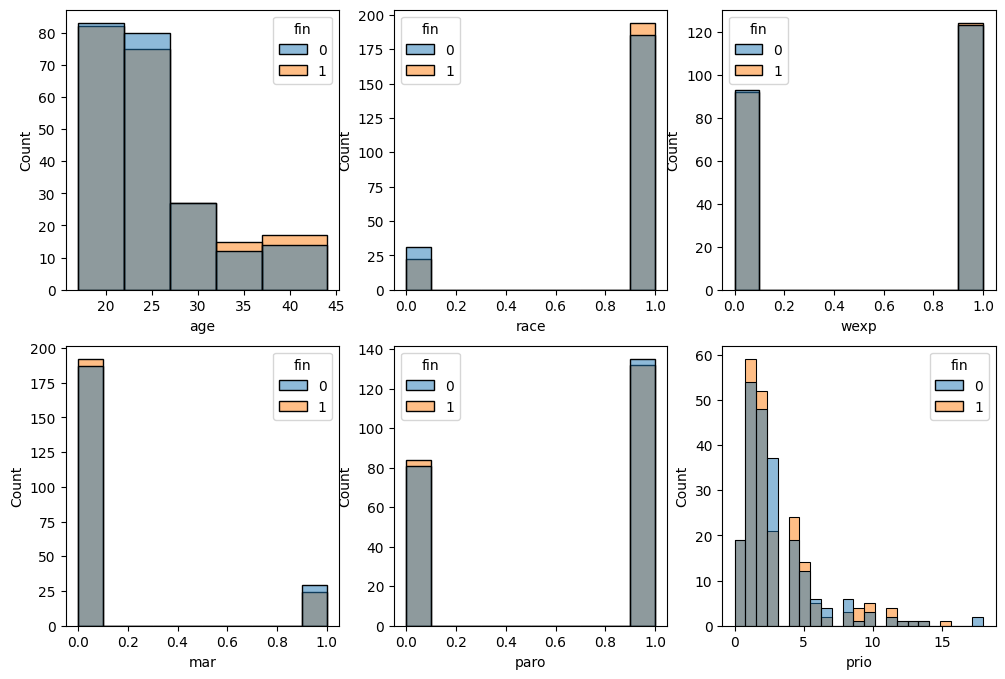

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
cols = df.columns.drop(['fin','week', 'arrest'])
axes = ax.ravel() 
for id, col in enumerate(cols):
    _ax = axes[id] 
    bins = [17, 22, 27, 32, 37, 44] if col == 'age' else 'auto'
    sns.histplot(data=df, x=col, hue='fin', alpha=0.5, bins=bins, ax=_ax)
    _ax.set_xlabel(col)

## Hazard Ratio & Interpretations

## Model Evaluataion 

If censoring is present, it’s not appropriate to use a loss function like mean-squared-error or mean-absolute-loss. This is because the difference between a censored value and the predicted value could be due to poor prediction or due to censoring. Below we introduce alternative ways to measure prediction performance.

### Concordance Index [C-index]


$$ C-index := \frac{\#  concordant \,\,\, pairs}{\# comparable \,\,\,  pairs} $$

- Concordant pair: the pair $(i, j)$ is concordant if $t_i > t_j$ and $\hat t_i > \hat t_j$ where $t$ is the observed time and $\hat t$ is the estimated survival time
- Comparable pairs: 

<img src="image.png" alt="drawing" width="500"/>

## Model Calibration

ICI =  0.0036926057314467567
E50 =  0.003442100352935129


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 25 mortality'}, xlabel='Predicted probability of \nt ≤ 25 mortality', ylabel='Observed probability of \nt ≤ 25 mortality'>,
 np.float64(0.0036926057314467567),
 np.float64(0.003442100352935129))

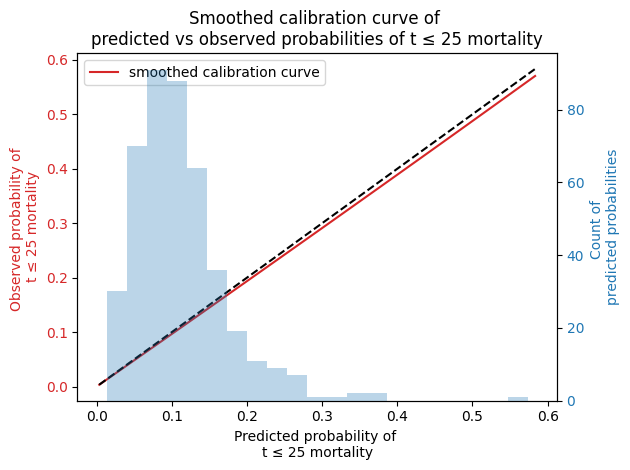

In [ ]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
from lifelines.calibration import survival_probability_calibration

regression_dataset = load_rossi()
cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
cph.fit(rossi, "week", "arrest")

survival_probability_calibration(cph, rossi, t0=25);

## Predictions

In [ ]:
Prediction

# Checking Proportional Hazard Assumption Evaluation

It is important to note that if the graph of the hazards cross for two or more categories of a predictor of interest, the PH assumption is not met. However, althought the hazard functions do not cross, it is possible that the PH assumption is not met. Thus, rather than checking for crossing hazards, we need to use other apporaches.

In [ ]:
# It seems that the proportional hazards assumption is violated as the log-log survival curves are not parallel.

## Further Reading
parametric and non-parametric models

ML Models 
- Survival Trees
- Support Vector Machine
- Baysian Survival Analysis
- Deep Survival Analysis